In [1]:
import numpy as np
from netCDF4 import Dataset
import itertools
import matplotlib.pyplot as plt
import datetime
from matplotlib import gridspec
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

In [2]:
# create days and dates list from 01/10/2010 - 30/04/2011
days_short = np.arange(0,212)
dates_short = [datetime.date(2010,10,1)+datetime.timedelta(days=np.int(days)) for days in days_short]
doys_short = np.array([x.timetuple().tm_yday for x in dates_short])
# create days and dates list from 01/01/2010 - 30/04/2021
days_long = np.arange(0,4138)
dates_long = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days_long]
doys_long = np.array([x.timetuple().tm_yday for x in dates_long])

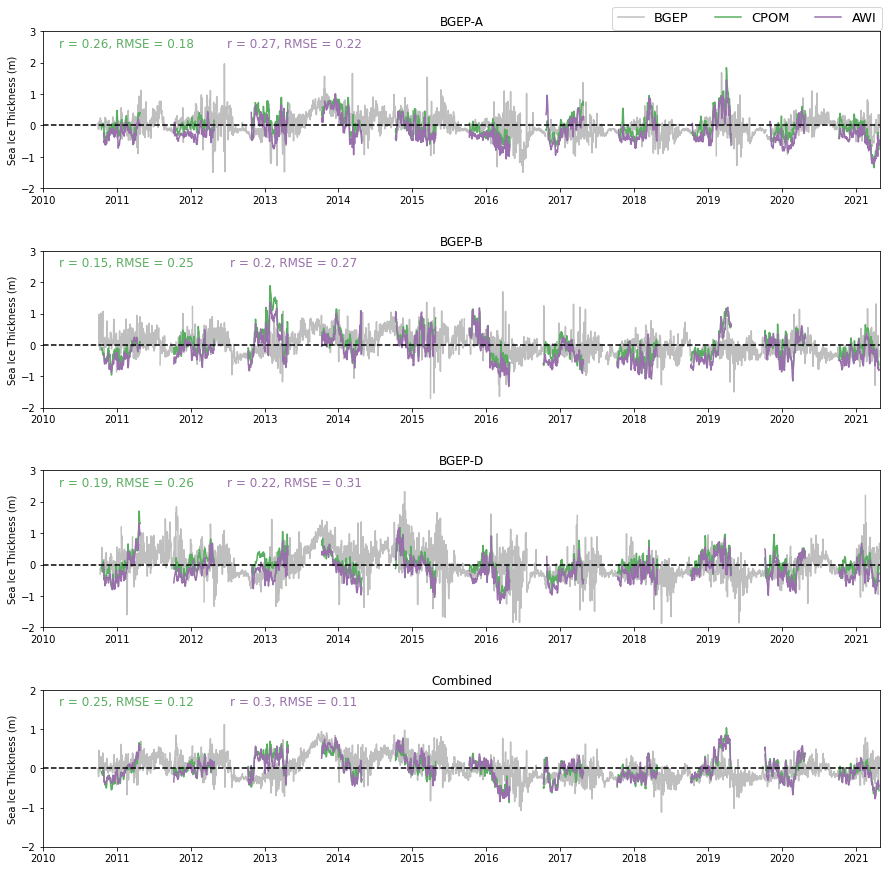

In [3]:
buoys = ['ULS_A','ULS_B','ULS_D']
buoy_names = ['BGEP-A','BGEP-B','BGEP-D']

datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/'

fig = plt.figure(figsize=(15,15))
spec = gridspec.GridSpec(ncols=1, nrows=4, wspace=0.25, hspace=0.4)

### plot buoys seperately

for count, buoy in enumerate(buoys):
    
    bgep = np.asarray(Dataset(datapath+'validation/BGEP/'+buoy+'/SIT_EASE_01Jan2010-31Jul2021.nc')
                      ['Sea Ice Thickness'])[:4138]
    cpom = np.asarray(Dataset(datapath+'sit/SMLG_CPOM/'+buoy+'/a100.nc')['Sea Ice Thickness'])
    awi = np.asarray(Dataset(datapath+'sit/SMLG_AWI/'+buoy+'/a100.nc')['Sea Ice Thickness'])
    
    ### create daily climatology for cs2
    days = np.arange(0,367)
    cpom_clim = np.array([np.nanmean(cpom[doys_long==day]) for day in days])
    awi_clim = np.array([np.nanmean(awi[doys_long==day]) for day in days])
    buoy_clim = np.array([np.nanmean(bgep[doys_long==day]) for day in days])

    ### create daily anomalies for cs2
    cpom_anoms = np.array([cs2-cpom_clim[doy] for doy,cs2 in zip(doys_long,cpom)]) 
    awi_anoms = np.array([cs2-cpom_clim[doy] for doy,cs2 in zip(doys_long,awi)]) 
    buoy_anoms = np.array([buoy-buoy_clim[doy] for doy,buoy in zip(doys_long,bgep)])
    
    days = np.arange(0,4138)
    sits = [cpom_anoms,awi_anoms]
    names = ['CPOM','AWI']
    colors = ['#5aae61','#9970ab']
    xs = [0.1,0.3]
    
    rs = {}
    rmses = {}
    
    ax = fig.add_subplot(spec[count])
    ax.plot(days,buoy_anoms,label='BGEP', color='grey',alpha=0.5)
    
    for sit,name,c,x in zip(sits,names,colors,xs):
        mask = ~np.isnan(buoy_anoms) & ~np.isnan(sit) # mask out cells with nan bgep or nan cs2
        if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in cs2 and bgep have data then continue
            rstats = linregress(buoy_anoms[mask],sit[mask]) # correlate valid bgep and cs2 for each grid cell 
            rs[name] = rstats.rvalue
        rmses[name] = np.nanmean(((sit-buoy_anoms)**2))
        ax.plot(days,sit,label=name,color=c)
        ax.text(x, 0.9, ('r = ' + str(np.round(rs[name],2)) + ', RMSE = '+ str(np.round(rmses[name],2))), ha='center',fontsize = 12,color=c,transform = ax.transAxes)

    ax.set_title(buoy_names[count])
    ax.set_ylim(-2,3)
    ax.set_xlim(0,4138)
    ax.set_ylabel('Sea Ice Thickness (m)')
    ax.set_xticks([0,365,730,1096,1461,1826,2191,2557,2922,3287,3652,4018])
    ax.set_xticklabels(['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021'])
    ax.axhline(0,linestyle='dashed',color='black')
    
    if count == 0:
        ax.legend(bbox_to_anchor = (1.01, 1.2),fontsize=13,ncol=3)
        
### plot combined buoys

names = ['CPOM','AWI']
means = {}
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/sit/'

for name in names:
    a = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_A/a100.nc')['Sea Ice Thickness'])
    b = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_B/a100.nc')['Sea Ice Thickness'])
    d = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_D/a100.nc')['Sea Ice Thickness'])
    name_means = np.nanmean(np.array([a,b,d]), axis=0)
    means[name] = name_means
    
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/validation/BGEP/'
bgep_a = np.asarray(Dataset(datapath+'ULS_A/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])
bgep_b = np.asarray(Dataset(datapath+'ULS_B/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])
bgep_d = np.asarray(Dataset(datapath+'ULS_D/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])

bgep = np.nanmean(np.array([bgep_a,bgep_b,bgep_d]), axis=0)[:4138]

### create daily climatologies for buoys and cs2
days = np.arange(0,367)
buoy_avs = np.array([np.nanmean(bgep[doys_long==day]) for day in days])
buoy_anoms = np.array([buoy-buoy_avs[doy] for doy,buoy in zip(doys_long,bgep)])

cpom_avs = np.array([np.nanmean(means['CPOM'][doys_long==day]) for day in days])
cpom_anoms = np.array([cs2-cpom_avs[doy] for doy,cs2 in zip(doys_long,means['CPOM'])])

awi_avs = np.array([np.nanmean(means['AWI'][doys_long==day]) for day in days])
awi_anoms = np.array([cs2-awi_avs[doy] for doy,cs2 in zip(doys_long,means['AWI'])])

#### plot
rs = {}
rmses = {}
anoms = [cpom_anoms,awi_anoms]

ax = fig.add_subplot(spec[3])
days = np.arange(0,4138)
ax.plot(days,buoy_anoms,label='BGEP', color='grey',alpha=0.5)

for sit,name,c,x in zip(anoms,names,colors,xs):
    mask = ~np.isnan(buoy_anoms) & ~np.isnan(sit) # mask out cells with nan bgep or nan cs2
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in cs2 and bgep have data then continue
        rstats = linregress(buoy_anoms[mask],sit[mask]) # correlate valid bgep and cs2 for each grid cell 
        rs[name] = rstats.rvalue
    rmses[name] = np.nanmean(((sit-buoy_anoms)**2))
    ax.plot(days,sit,label=name,color=c)
    ax.text(x, 0.9, ('r = ' + str(np.round(rs[name],2)) + ', RMSE = '+ str(np.round(rmses[name],2))), ha='center',fontsize = 12,color=c,transform = ax.transAxes)

ax.set_ylim(-2,2)
ax.set_xlim(0,4138)
ax.set_ylabel('Sea Ice Thickness (m)')
ax.set_xticks([0,365,730,1096,1461,1826,2191,2557,2922,3287,3652,4018])
ax.set_xticklabels(['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021'])
ax.set_title('Combined')
ax.axhline(0,linestyle='dashed',color='black')
        
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/main_figs/bgep_anoms_timeseries.jpg',bbox_inches = "tight", dpi = 400)